In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve,log_loss,average_precision_score
from sklearn.metrics import f1_score
import random
import gc
from catboost import CatBoostClassifier
%matplotlib inline

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = pd.read_csv('df_sortprob_23_no_test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
seed = 1121
np.random.seed(seed)
random.seed(seed)

In [7]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [8]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [9]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [10]:
def group_ag(main_columns, uids, train_df, test_df, aggregations=['mean'],
              fillna = True):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'__'+col+'_'+agg_type
                #拼接训练集和测试集
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])  
                #求AGG
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # 取出目标列作为索引
                temp_df.index = list(temp_df[col])
                # 生成map对应的字典
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)  
                    
                print("'"+new_col_name+"'",', ',end='')
#group_ag(['conam'],['cano'],df,df_test,['mean','std'])
#df['conam_cano_std'].value_counts()

In [11]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [12]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [13]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [14]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
#big_top_value_cols.remove('iterm')
#big_top_value_cols.remove('hcefg')
#big_top_value_cols.remove('contp')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [15]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [ ]:
#use label encoding
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('flbmk')
cat_cols.remove('flg_3dsmk')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

In [16]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [17]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [18]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
import copy
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')
(1521787, 19)


In [19]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

## 從這裡開始

In [21]:
# 指定分类特征
categorical_features = ['acqic', 'csmcu', 'ecfg', 'etymd',
        'mcc', 'mchno', 'scity', 'stocn',
       'stscd','stocn_scity' ,'mcc_mchno'
                       ]

In [22]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

19
18
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')


In [23]:
#新特徵
encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('cano','loctm_hour',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)
encode_CB('cano','locdt',df,df_test)
encode_CB('cano','stocn',df,df_test)

    


bacno_cano , mcc_mchno , stocn_scity , stscd_csmcu , cano_loctm_hour , cano_mcc_mchno , cano_locdt , cano_stocn , 

In [72]:
count_features =['acqic', 'bacno', 'cano', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   

encode_FE(df,df_test,count_features)
cf =  ['bacno_FE' , 'cano_FE' , 'conam_FE' , 'etymd_FE' , 'mcc_FE' ,
        'stocn_FE' , 'loctm_hour_FE' , 'stocn_scity_FE'  ]

acqic_FE , bacno_FE , cano_FE , conam_FE , csmcu_FE , ecfg_FE , etymd_FE , mcc_FE , mchno_FE , scity_FE , stocn_FE , stscd_FE , loctm_hour_FE , stocn_scity_FE , mcc_mchno_FE , 

In [116]:
col1s = ['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   

for col in col1s:      
    group_ag([col],['cano'],df,df_test,['mean','std'])  
#show_cor(df)

'acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , 

In [91]:
gf=['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]

In [93]:
re_gf =['etymd__cano_std' , 'stscd__cano_std' ]

In [94]:
gf = set(gf) -set(re_gf)

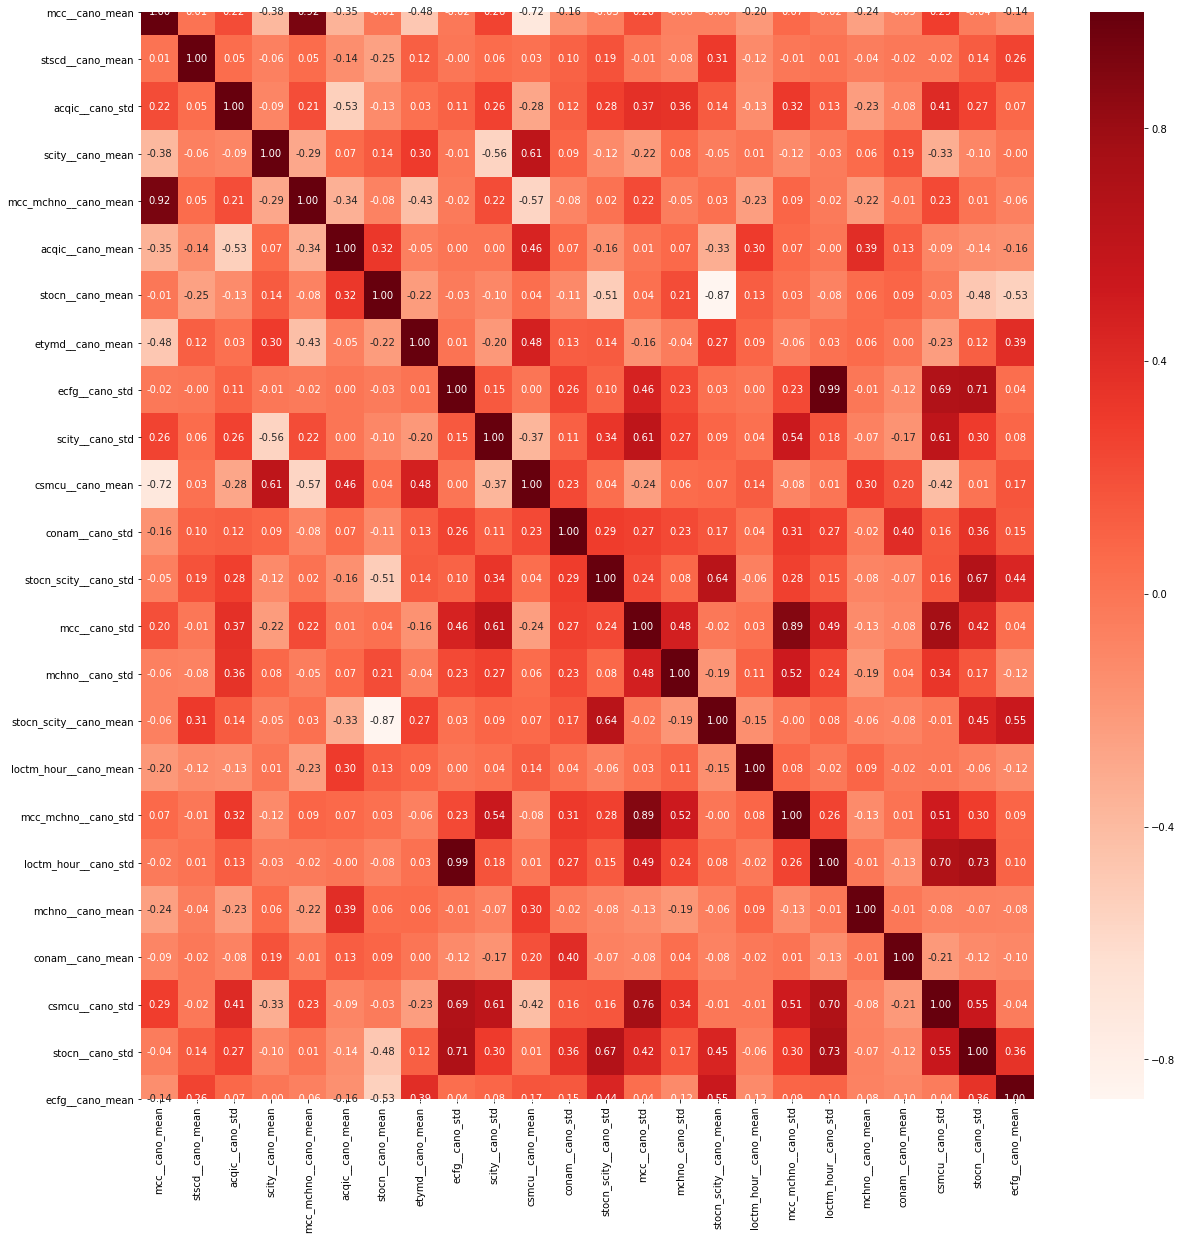

In [95]:
show_cor(df[gf])

In [ ]:
col1s = ['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']    

re_num_2 =['ecfg']']
mcc_mre =['csmcu','mcc','mcc_mchno','mchno']
sto_r =['scity', 'stocn','stocn_scity']
new = set(col1s)-set(re_num_2)-set(mcc_mre)#-set(sto_r)
for col in list(new):      
    group_ag([col],['cano_mcc_mchno'],df,df_test,['mean','std'])  


In [ ]:
gf2=['stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , ]

In [ ]:
gf3 =['stocn__cano_mcc_mchno_mean' , 'stocn__cano_mcc_mchno_std' , 'stocn_scity__cano_mcc_mchno_mean' , 'stocn_scity__cano_mcc_mchno_std' , 'scity__cano_mcc_mchno_mean' , 'scity__cano_mcc_mchno_std' , 'acqic__cano_mcc_mchno_mean' , 'acqic__cano_mcc_mchno_std' , 'conam__cano_mcc_mchno_mean' , 'conam__cano_mcc_mchno_std' , ]

In [ ]:
gf4=['csmcu__cano_stocn_mean' , 'csmcu__cano_stocn_std' , 'mcc_mchno__cano_stocn_mean' , 'mcc_mchno__cano_stocn_std' , 'mcc__cano_stocn_mean' , 'mcc__cano_stocn_std' , 'mchno__cano_stocn_mean' , 'mchno__cano_stocn_std' , 'acqic__cano_stocn_mean' , 'acqic__cano_stocn_std' , 'conam__cano_stocn_mean' , 'conam__cano_stocn_std' ,  ]

In [ ]:
show_cor(df[gf3])

In [ ]:
cols1 =['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'stscd', 'loctm_hour','stocn_scity']
cols2 =['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'stscd', 'loctm_hour', 'stocn_scity']
for col1 in cols1:
    for col2 in cols2:
        encode_CB(col1,col2,df,df_test)

In [ ]:
#DECREASE FEATURE
col1s = ['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno'] 

cols2 =['cano_mcc_mchno']
for col1 in new:
    for col2 in cols2:              
        model1_features =['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
        'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn',
        'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]      
        #combine feature
        #model1_features.append(col1+'_'+col2)
        #count feature
        #model1_features.append(col1+'_FE')
        #group feature 
        temp = model1_features+cf+list(gf)+list(gf2)+list(gf3)+list(gf4)#- set(remove_f)
        model1_features= temp.copy()
        print('now remove '+col1+'__'+col2)
        model1_features.remove(col1+'__'+col2+'_mean')
        #if(not(col1=='etymd' or col1=='stscd' or col1 =='loctm_hour')): 
        model1_features.remove(col1+'__'+col2+'_std') 
        model1_features.sort()        
        X_train = df[model1_features]
        Y_train = df['fraud_ind'] 
        df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
        df_train_2 = df.iloc[:int(0.8 * len(df)), ]
        train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
        valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
        print()
        print('train_df.columns = ',train_df.columns)
        print('train_df.shape = ',train_df.shape)
        
        clf = CatBoostClassifier(**params) 
        clf.fit(train_df,y_train_df,
                eval_set=(valid_df, y_valid_df),
                cat_features=categorical_features,
                use_best_model=True,
                early_stopping_rounds=200,
                verbose=10)
        pred = clf.predict_proba(valid_df)[:,1]
        
        now_auc = roc_auc_score(y_valid_df, pred)
        print( "      auc = ", now_auc ) 
        pred_file_path = 'compare.csv'
        last_pred = np.array(pd.read_csv(pred_file_path))
        last_auc = roc_auc_score(y_valid_df, last_pred)
        print( "last  auc = ", last_auc ) 
    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]  
        last_y_pre = [int(item>threshold) for  item in last_pred] 
        now_f1= f1_score(y_valid_df, y_pre)
        last_f1 =f1_score(y_valid_df, last_y_pre)
        print( "     f1 = ", now_f1)
        print( "last f1 = ", last_f1)
        now_ap = average_precision_score(y_valid_df, pred);
        print( "     average_precision = ",now_ap)
        last_ap =average_precision_score(y_valid_df, last_pred)
        print( "last average_precision = ",last_ap)
        count=0
        if(now_ap>=last_ap):
            count=count+1
            print('ap improve')            
        if(now_f1>=last_f1):
            count=count+1
            print('f1 improve')          
        if(now_auc>=last_auc):      
            count=count+1
            print('auc improve')            
        if(count>0 or now_ap>=last_ap):
            show_pr()
            #print('-------------------------------------',col1+'_'+col2,'count=',count)
            #print('-------------------------------------',col1+'_FE','count=',count)
            print('-------------------------------------',col1+'_'+col2,'count=',count)  
        print('-------------------------------------------------------------------------')     
        del clf
        gc.collect()
        gc.collect()
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )


train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'acqic__cano_mean', 'acqic__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630199	best: 0.6630199 (0)	total: 107ms	remaining: 17m 48s
500:	learn: 0.1239062	test: 0.1412894	best: 0.1412894 (500)	total: 52.3s	remaining: 16m 31s
1000:	learn: 0.0978241	test: 0.1330377	best: 0.1330180 (998)	total: 1m 44s	remaining: 15m 43s
1500:	learn: 0.0819381	test: 0.1307604	best: 0.1307140 (1495)	total: 2m 37s	remaining: 14m 53s
bestTest = 0.130714019
bestIteration = 1495
Shrink model to first 1496 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


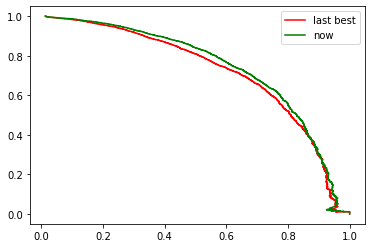

------------------------------------- acqic_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'conam__cano_mean', 'conam__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631407	test: 0.6630197	best: 0.6630197 (0)	total: 99.6ms	remaining: 16m 35s
500:	learn: 0.1213736	test: 0.1407876	best: 0.1407876 (500)	total: 51.8s	remaining: 16m 22s
1000:	learn: 0.0951395	test: 0.1330566	best: 0.1330566 (1000)	total: 1m 44s	remaining: 15m 40s
1500:	learn: 0.0790120	test: 0.1315131	best: 0.1315131 (1500)	total: 2m 37s	remaining: 14m 52s
bestTest = 0.1315129124
bestIteration = 1501
Shrink model to first 1502 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


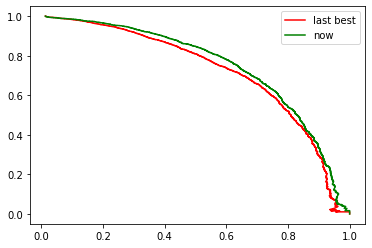

------------------------------------- conam_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'csmcu__cano_mean', 'csmcu__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631407	test: 0.6630198	best: 0.6630198 (0)	total: 101ms	remaining: 16m 48s
500:	learn: 0.1264014	test: 0.1442982	best: 0.1442982 (500)	total: 51.7s	remaining: 16m 20s
1000:	learn: 0.1010504	test: 0.1375773	best: 0.1375773 (1000)	total: 1m 44s	remaining: 15m 36s
1500:	learn: 0.0851672	test: 0.1359427	best: 0.1358414 (1368)	total: 2m 36s	remaining: 14m 47s
bestTest = 0.1358413987
bestIteration = 1368
Shrink model to first 1369 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


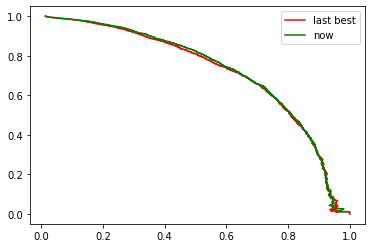

------------------------------------- csmcu_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'ecfg__cano_mean', 'ecfg__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630199	best: 0.6630199 (0)	total: 100ms	remaining: 16m 41s
500:	learn: 0.1228242	test: 0.1415081	best: 0.1415081 (500)	total: 51.2s	remaining: 16m 9s
1000:	learn: 0.0967573	test: 0.1344178	best: 0.1344083 (994)	total: 1m 43s	remaining: 15m 29s
1500:	learn: 0.0805336	test: 0.1323801	best: 0.1323801 (1500)	total: 2m 36s	remaining: 14m 43s
bestTest = 0.1323342676
bestIteration = 1508
Shrink model to first 1509 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


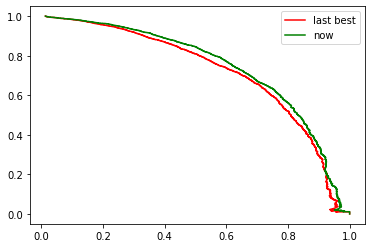

------------------------------------- ecfg_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'etymd__cano_mean', 'etymd__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630200	best: 0.6630200 (0)	total: 99.4ms	remaining: 16m 34s
500:	learn: 0.1244405	test: 0.1417914	best: 0.1417914 (500)	total: 51.9s	remaining: 16m 23s
1000:	learn: 0.0977491	test: 0.1335530	best: 0.1335530 (1000)	total: 1m 44s	remaining: 15m 40s
1500:	learn: 0.0817079	test: 0.1319467	best: 0.1319436 (1393)	total: 2m 37s	remaining: 14m 52s
bestTest = 0.1319294837
bestIteration = 1502
Shrink model to first 1503 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


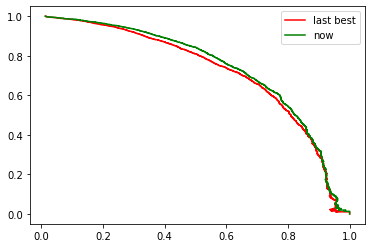

------------------------------------- etymd_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'mcc__cano_mean', 'mcc__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631407	test: 0.6630197	best: 0.6630197 (0)	total: 99.7ms	remaining: 16m 36s
500:	learn: 0.1250362	test: 0.1420330	best: 0.1420330 (500)	total: 51.2s	remaining: 16m 10s
1000:	learn: 0.0977356	test: 0.1330450	best: 0.1330348 (998)	total: 1m 43s	remaining: 15m 32s
1500:	learn: 0.0814506	test: 0.1310066	best: 0.1309641 (1474)	total: 2m 36s	remaining: 14m 45s
2000:	learn: 0.0698600	test: 0.1314828	best: 0.1308036 (1817)	total: 3m 28s	remaining: 13m 55s
bestTest = 0.1308035518
bestIte

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


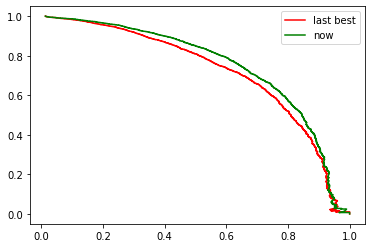

------------------------------------- mcc_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'mchno__cano_mean', 'mchno__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630201	best: 0.6630201 (0)	total: 99.4ms	remaining: 16m 34s
500:	learn: 0.1198811	test: 0.1388615	best: 0.1388615 (500)	total: 51.7s	remaining: 16m 19s
1000:	learn: 0.0941989	test: 0.1313888	best: 0.1313870 (999)	total: 1m 44s	remaining: 15m 37s
1500:	learn: 0.0783401	test: 0.1300294	best: 0.1299867 (1477)	total: 2m 37s	remaining: 14m 51s
bestTest = 0.129986689
bestIteration = 1477
Shrink model to first 1478 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


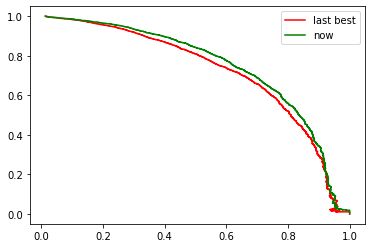

------------------------------------- mchno_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'scity__cano_mean', 'scity__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630200	best: 0.6630200 (0)	total: 100ms	remaining: 16m 40s
500:	learn: 0.1233803	test: 0.1406938	best: 0.1406938 (500)	total: 52.5s	remaining: 16m 35s
1000:	learn: 0.0978178	test: 0.1324729	best: 0.1324363 (993)	total: 1m 44s	remaining: 15m 43s
1500:	learn: 0.0815957	test: 0.1299103	best: 0.1298560 (1482)	total: 2m 37s	remaining: 14m 53s
bestTest = 0.1293946275
bestIteration = 1690
Shrink model to first 1691 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


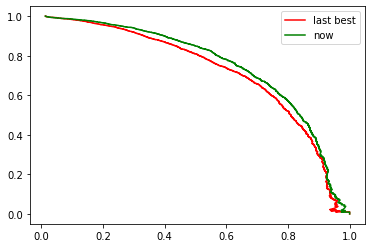

------------------------------------- scity_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'stocn__cano_mean', 'stocn__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631407	test: 0.6630199	best: 0.6630199 (0)	total: 99.9ms	remaining: 16m 38s
500:	learn: 0.1223381	test: 0.1410812	best: 0.1410812 (500)	total: 51.4s	remaining: 16m 13s
1000:	learn: 0.0972708	test: 0.1340386	best: 0.1339793 (984)	total: 1m 43s	remaining: 15m 32s
1500:	learn: 0.0813989	test: 0.1321974	best: 0.1321924 (1493)	total: 2m 35s	remaining: 14m 43s
bestTest = 0.1319070481
bestIteration = 1551
Shrink model to first 1552 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


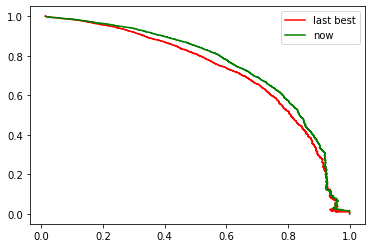

------------------------------------- stocn_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'stscd__cano_mean', 'stscd__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6621102	test: 0.6619682	best: 0.6619682 (0)	total: 99.4ms	remaining: 16m 34s
500:	learn: 0.1225357	test: 0.1404366	best: 0.1404366 (500)	total: 51.5s	remaining: 16m 16s
1000:	learn: 0.0986475	test: 0.1338491	best: 0.1338491 (1000)	total: 1m 43s	remaining: 15m 29s
1500:	learn: 0.0834176	test: 0.1326882	best: 0.1325244 (1450)	total: 2m 35s	remaining: 14m 42s
bestTest = 0.1325244266
bestIteration = 1450
Shrink model to first 1451 iterations.
ap improve
f1 improve
auc improve


/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


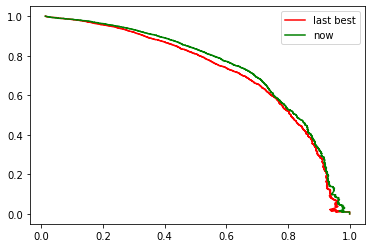

------------------------------------- stscd_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631408	test: 0.6630199	best: 0.6630199 (0)	total: 99.8ms	remaining: 16m 37s
500:	learn: 0.1201249	test: 0.1388255	best: 0.1388255 (500)	total: 51.7s	remaining: 16m 19s
1000:	learn: 0.0939244	test: 0.1305303	best: 0.1304443 (996)	total: 1m 43s	remaining: 15m 34s
1500:	learn: 0.0780068	test: 0.1280985	best: 0.1280985 (1500)	total: 2m 36s	remaining: 14m 46s
bestTest = 0.1280892501
bestIteration = 1505
Shrink model to first 1506 iterations.
ap improve
f1 improve

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


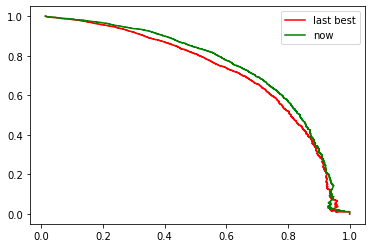

------------------------------------- loctm_hour_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'stocn_scity__cano_mean',
       'stocn_scity__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631409	test: 0.6630199	best: 0.6630199 (0)	total: 100ms	remaining: 16m 41s
500:	learn: 0.1223906	test: 0.1392863	best: 0.1392863 (500)	total: 52.3s	remaining: 16m 30s
1000:	learn: 0.0953917	test: 0.1318618	best: 0.1318590 (999)	total: 1m 44s	remaining: 15m 41s
1500:	learn: 0.0792519	test: 0.1302685	best: 0.1300525 (1388)	total: 2m 37s	remaining: 14m 53s
bestTest = 0.1300525289
bestIteration = 1388
Shrink model to first 1389 iterations.
ap improve
f1 i

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


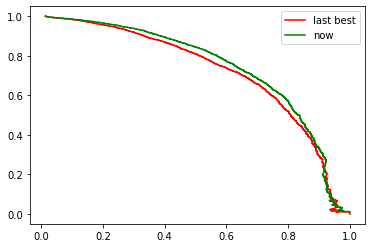

------------------------------------- stocn_scity_cano count= 3
-------------------------------------------------------------------------

train_df.columns =  Index(['etymd', 'stocn_scity', 'loctm_hour_FE', 'loctm_hour', 'cano_FE',
       'csmcu', 'stocn_FE', 'mchno', 'conam', 'mcc_FE', 'conam_FE', 'stscd',
       'acqic', 'etymd_FE', 'mcc_mchno', 'ecfg', 'stocn_scity_FE', 'stocn',
       'mcc', 'scity', 'bacno_FE', 'mcc_mchno__cano_mean',
       'mcc_mchno__cano_std'],
      dtype='object')
train_df.shape =  (1217429, 23)
0:	learn: 0.6631406	test: 0.6630199	best: 0.6630199 (0)	total: 100ms	remaining: 16m 41s
500:	learn: 0.1229354	test: 0.1408315	best: 0.1408315 (500)	total: 51.8s	remaining: 16m 22s
1000:	learn: 0.0967436	test: 0.1320558	best: 0.1320558 (1000)	total: 1m 44s	remaining: 15m 39s
1500:	learn: 0.0808549	test: 0.1304624	best: 0.1304478 (1478)	total: 2m 37s	remaining: 14m 51s
bestTest = 0.1302167161
bestIteration = 1708
Shrink model to first 1709 iterations.
ap improve
f1 imp

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


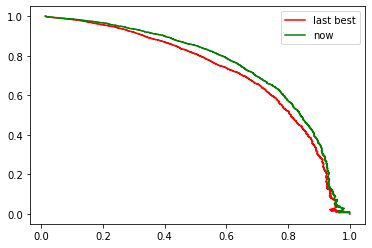

------------------------------------- mcc_mchno_cano count= 3
-------------------------------------------------------------------------


In [90]:
#ADD FEATURE
col1s = ['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   

cols2 =['cano']
for col1 in col1s:
    for col2 in cols2:              
        model1_features =['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
        'mcc', 'mchno', 'scity', 'stocn',
        'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]      
        #combine feature
        #model1_features.append(col1+'_'+col2)
        #count feature
        #model1_features.append(col1+'_FE')
        #group feature 
        temp = set(model1_features+cf)#+list(gf)+list(gf2)+list(gf3))#- set(remove_f)
        model1_features = list(temp)     
        model1_features.append(col1+'__'+col2+'_mean')
        #if(not(col1=='etymd' or col1=='stscd' or col1 =='loctm_hour')): 
        model1_features.append(col1+'__'+col2+'_std')   
        model1_features.sort()
        X_train = df[model1_features]
        Y_train = df['fraud_ind'] 
        df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
        df_train_2 = df.iloc[:int(0.8 * len(df)), ]
        train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
        valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
        print()
        print('train_df.columns = ',train_df.columns)
        print('train_df.shape = ',train_df.shape)
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)  
        clf = CatBoostClassifier(**params,num_boost_round=10000,) 
        clf.fit(train_df,y_train_df,
                eval_set=(valid_df, y_valid_df),
                 cat_features=categorical_features,
                use_best_model=True,
                
                early_stopping_rounds=200,
                verbose=True)
        pred = clf.predict_proba(valid_df)[:,1]
        now_auc = roc_auc_score(y_valid_df, pred)
        #print( "      auc = ", now_auc ) 
        pred_file_path = 'compare_cat.csv'
        last_pred = np.array(pd.read_csv(pred_file_path))
        last_auc = roc_auc_score(y_valid_df, last_pred)
        #print( "last  auc = ", last_auc ) 
    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]  
        last_y_pre = [int(item>threshold) for  item in last_pred] 
        now_f1= f1_score(y_valid_df, y_pre)
        last_f1 =f1_score(y_valid_df, last_y_pre)
        #print( "     f1 = ", now_f1)
        #print( "last f1 = ", last_f1)
        now_ap = average_precision_score(y_valid_df, pred);
        #print( "     average_precision = ",now_ap)
        last_ap =average_precision_score(y_valid_df, last_pred)
        #print( "last average_precision = ",last_ap)
        count=0
        if(now_ap>last_ap):
            count=count+1
            print('ap improve')            
        if(now_f1>last_f1):
            count=count+1
            print('f1 improve')          
        if(now_auc>last_auc):      
            count=count+1
            print('auc improve')            
        if(count>0 or now_ap>last_ap):
            show_pr()
            #print('-------------------------------------',col1+'_'+col2,'count=',count)
            #print('-------------------------------------',col1+'_FE','count=',count)
            print('-------------------------------------',col1+'_'+col2,'count=',count)  
        print('-------------------------------------------------------------------------')     
        del clf 
        gc.collect()
        gc.collect()
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )


In [98]:
model1_features =['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+cf+list(gf)#+list(gf2)+list(gf3)+list(gf4)
model1_features= temp.copy()
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
#show_cor(df[model1_features])

45
Index(['acqic', 'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'conam', 'conam_FE', 'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean',
       'ecfg__cano_std', 'etymd', 'etymd_FE', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_mean', 'loctm_hour__cano_std', 'mcc',
       'mcc_FE', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno__cano_mean', 'mcc_mchno__cano_std', 'mchno',
       'mchno__cano_mean', 'mchno__cano_std', 'scity', 'scity__cano_mean',
       'scity__cano_std', 'stocn', 'stocn_FE', 'stocn__cano_mean',
       'stocn__cano_std', 'stocn_scity', 'stocn_scity_FE',
       'stocn_scity__cano_mean', 'stocn_scity__cano_std', 'stscd',
       'stscd__cano_mean'],
      dtype='object')


In [99]:
# 将概率最大的20%作为验证集
df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
df_train_2 = df.iloc[:int(0.8 * len(df)), ]

In [100]:
import time
predictions = np.zeros(len(X_test))

In [101]:
params = {  'learning_rate': 0.07,
            'eval_metric':'Logloss',
            'loss_function':'Logloss',
            'random_seed':seed,
            'metric_period':500,
            'od_wait':500,
            'scale_pos_weight':73.76231884057971,
            'task_type':'GPU',
            'depth': 8,
            'gpu_ram_part':0.5,
            'devices':'3',
           'learning_rate':0.02
             }

In [102]:
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
    
    clf = CatBoostClassifier(**params,num_boost_round=10000,) 
    clf.fit(train_df,y_train_df,
                eval_set=(valid_df, y_valid_df),
                 cat_features=categorical_features,
                use_best_model=True,
                
                early_stopping_rounds=200,
                verbose=True)
    pred = clf.predict_proba(valid_df)[:,1]
    
    
    pred_file_path = 'compare_cat.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))   
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

  
    #precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)
    #plt.figure(figsize=(10,6))
    #plt.plot(precision_now,recall_now,label="now pr ")
    #plt.xlabel('Recall',fontsize=16)
    #plt.ylabel('Precision',fontsize=16)
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(
    #      average_precision))   
    #plt.legend()  
   
   
    print('_'*100)
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

train_df.columns =  Index(['acqic', 'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'conam', 'conam_FE', 'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean',
       'ecfg__cano_std', 'etymd', 'etymd_FE', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_mean', 'loctm_hour__cano_std', 'mcc',
       'mcc_FE', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno__cano_mean', 'mcc_mchno__cano_std', 'mchno',
       'mchno__cano_mean', 'mchno__cano_std', 'scity', 'scity__cano_mean',
       'scity__cano_std', 'stocn', 'stocn_FE', 'stocn__cano_mean',
       'stocn__cano_std', 'stocn_scity', 'stocn_scity_FE',
       'stocn_scity__cano_mean', 'stocn_scity__cano_std', 'stscd',
       'stscd__cano_mean'],
      dtype='object')
train_df.shape =  (1217429, 45)
0:	learn: 0.6615184	test: 0.6611105	best: 0.6611105 (0)	total: 101ms	remaining: 16m 50s
500:	learn: 0.1064831	test:

last  auc =  0.9871866980280151


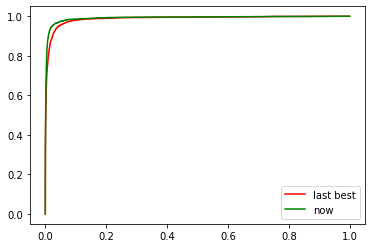

In [105]:
pred_file_path = 'compare_cat.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


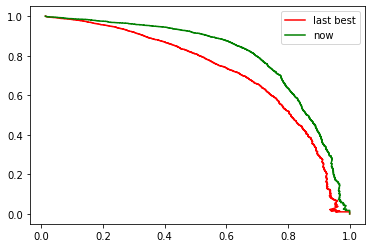

In [106]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

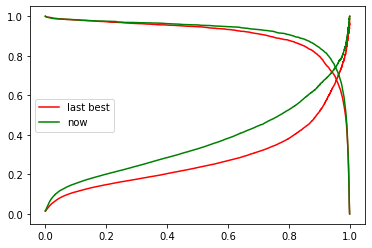

In [107]:
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [108]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare_cat.csv',index=None)

save  file...


In [ ]:
precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)

In [ ]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

## train start!

(1521787, 45)
train feature  Index(['acqic', 'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'conam', 'conam_FE', 'conam__cano_mean', 'conam__cano_std', 'csmcu',
       'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean',
       'ecfg__cano_std', 'etymd', 'etymd_FE', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_mean', 'loctm_hour__cano_std', 'mcc',
       'mcc_FE', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno__cano_mean', 'mcc_mchno__cano_std', 'mchno',
       'mchno__cano_mean', 'mchno__cano_std', 'scity', 'scity__cano_mean',
       'scity__cano_std', 'stocn', 'stocn_FE', 'stocn__cano_mean',
       'stocn__cano_std', 'stocn_scity', 'stocn_scity_FE',
       'stocn_scity__cano_mean', 'stocn_scity__cano_std', 'stscd',
       'stscd__cano_mean'],
      dtype='object')
____________________________________________________________________________________________________
Fold 0
0:	learn: 0.6627991	test: 0.66

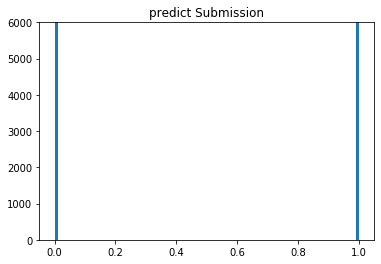

____________________________________________________________________________________________________
Fold 1
0:	learn: 0.6611726	test: 0.6624105	best: 0.6624105 (0)	total: 26.8ms	remaining: 0us
bestTest = 0.6624104782
bestIteration = 0
Shrink model to first 1 iterations.
  confusion_matrix = 
 [[458905  41443]
 [   523   6307]]


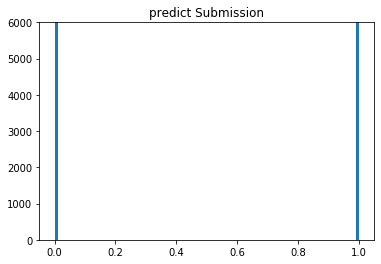

____________________________________________________________________________________________________
Fold 2
0:	learn: 0.6625675	test: 0.6629103	best: 0.6629103 (0)	total: 23.8ms	remaining: 0us
bestTest = 0.662910308
bestIteration = 0
Shrink model to first 1 iterations.
  confusion_matrix = 
 [[461161  39652]
 [   460   6001]]


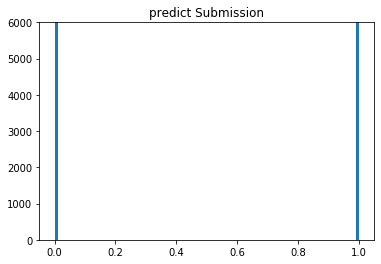

avg  auc =  0.965012701598285
avg  f1 =  0.23239632404831964
last oof  auc =  0.9651399127772702
oof  auc =  0.9651399127772702
last oof  f1 =  0.23244596861738873
oof  f1 =  0.23244596861738873
last oof  average_precision =  0.4377202940013219
oof  average_precision =  0.4377202940013219
confusion_matrix =
[[1378502  122930]
 [   1512   18843]]


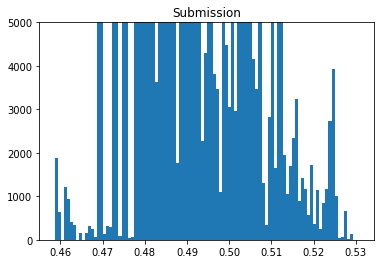

It cost 62.620542 sec


In [113]:
    tStart = time.time()#計時開始  
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    ##folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    print(X_train.shape)
    print('train feature ',X_train.columns)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        
        clf = CatBoostClassifier(**params,num_boost_round=1,) 
        clf.fit(train_df,y_train_df,
                eval_set=(valid_df, y_valid_df),
                cat_features=categorical_features,
                use_best_model=True,                
                early_stopping_rounds=200,
                verbose=True)        
        pred = clf.predict_proba(valid_df)[:,1]
        oof[val_idx] = pred
        #print(pred[0])
       
    
        #print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        #print( "  f1 = ", f1_score(y_valid_df, y_pre))
        print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)
        
        predictions += clf.predict_proba(X_test)[:,1] / splits
        
        gc.collect()
   
        prediction = [int(item>threshold) for  item in predictions]    
 
        plt.hist(y_pre,bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    pred_file_path = 'compare_fold_cat.csv'
    last_oof = np.array(pd.read_csv(pred_file_path))  
    print( "avg  auc = ", auc_avg/ splits )
    print( "avg  f1 = ", f1_avg/ splits)
    print( "last oof  auc = ", roc_auc_score(Y_train, last_oof) )
    print( "oof  auc = ", roc_auc_score(Y_train, oof) )  
    last_oof_threshold = [int(item>0.5) for  item in last_oof] 
    oof_threshold = [int(item>0.5) for  item in oof]
    print( "last oof  f1 = ", f1_score(Y_train, last_oof_threshold))
    print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
    print( "last oof  average_precision = ",average_precision_score(Y_train,last_oof))
    print( "oof  average_precision = ",average_precision_score(Y_train,oof))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train, oof_threshold))
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()  
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

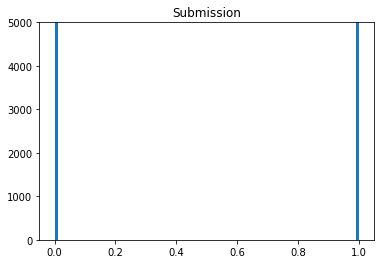

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 42123


In [114]:
# 结果保存
plt.hist(prediction,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = prediction
sampleSubmission.to_csv('submission_test.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])

In [115]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':oof})
last_pred.to_csv('compare_fold_cat.csv',index=None)

save  file...
